In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Solving simple differential equations with naive optimization

In this notebook, we investigate how does the optimization of the loss defined by sum of unsupervised minimalization of the equation and by supervised optimization for MSE for the boundary conditions
$$Loss(N)=\sum_i \left(\Delta\Psi(N(x_i))+E\Psi(N(x_i))\right)^2 + \sum_k (\Psi(N(x_k))-C_k)^2$$
works for simple ODEs.

This work is a mixture of methods and examples from
  1. Lagaris, I., Likas, A., & Fotiadis, D. 1997, Computer Physics Communications,104, 1
  1. Shirvany, et. al., "Numerical solution of the nonlinear Schrodinger equation by feedforward neural networks."

We define our model by

In [2]:
class Solution(tf.keras.models.Model):
  def __init__(self, n_i, n_h, n_o=2, activation='sigmoid'):
    super(Solution, self).__init__()
    
    # Dimension of all the layers
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    
    # Shallow network
    # Hidden layer
    self.hidden_layer = tf.keras.layers.Dense(units=n_h, activation=activation)
    # Output layer
    self.output_layer = tf.keras.layers.Dense(units=n_o, activation='linear')
    
  def call(self, X):
    # Conversion to a tensor
    X = tf.convert_to_tensor(X)
    
    # Simple Shallow Network Response
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    
    response = tf.math.reduce_prod(response, axis=1)
    
    return response
  
  def train(self, X, loss_function, epochs, conditions, eigen_value=None, verbose=True,
            message_frequency=1, learning_rate=0.1, boundary_multiplier=10,
            optimizer_name='Adam'):
    
    # Checking for the right parameters
    if not isinstance(epochs, int) or epochs < 1:
      raise Exception('epochs parameter should be a positive integer.')
    if not isinstance(message_frequency, int) or message_frequency < 1:
      raise Exception(
                'message_frequency parameter should be a positive integer.')
      
    # Choosing the optimizers
    optimizer = None
    if optimizer_name == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    
    def loss_boundary(network, conditions):
      loss = tf.constant(0., shape=(1,), dtype='float64')
      for condition in conditions:
        X = tf.constant(condition['value'], shape=(1,1), dtype='float64')
        boundary_response = None
        if condition['type'] == 'dirichlet':
          boundary_response = network(X)
        elif condition['type'] == 'neuman':
          with tf.GradientTape() as tape:
            tape.watch(X)
            response = network(X)
          boundary_response = tape.gradient(response, X)
        else:
          raise Exception('Wrong type of condition.')
        boundary_response = tf.reshape(boundary_response, shape=(-1,))
        boundary_value = condition['function'](X)
        boundary_value = tf.reshape(boundary_value, shape=(-1,))
        loss += (boundary_response - boundary_value) ** 2
      loss = boundary_multiplier*tf.math.reduce_sum(loss)
      return loss

    # Single train step function for the unsupervised equation part
    @tf.function
    def train_step(X, conditions, eigen_value):
      with tf.GradientTape() as tape:
        loss = loss_function(self, X, eigen_value)
      gradients = tape.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      with tf.GradientTape() as tape2:
        loss = loss_boundary(self, conditions)
      gradients = tape2.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      
    # Training for a given number of epochs
    for epoch in range(epochs):
      train_step(X, conditions, eigen_value)
      equation_loss = loss_function(self, X, eigen_value)
      boundary_loss = loss_boundary(self, conditions)
      if verbose and(epoch+1) % message_frequency == 0:
        print(f'Epoch: {epoch+1} Loss equation: \
              {equation_loss.numpy()} \
              Loss boundary: {boundary_loss.numpy()}')

# Example 1
$$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$$
With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [3]:
def constant(c):
  def func(X):
    return tf.constant(c, dtype='float64', shape=X.shape)
  return func
inits = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':constant(1)}]

Defining the domain - train and test input sets.

In [4]:
X_train = np.arange(0, 1.1, 0.01) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 1.1, 0.01) + 1e-8
X_test = X_test.reshape(-1,1) 

The loss for this equation.

In [5]:
def diff_loss(network, inputs, *args):
  # Compute the gradients
  with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(inputs)
    tape.watch(inputs)
    response = network(inputs)
  grads = tf.reshape(tape.gradient(response, inputs), shape=(-1,))
  X = tf.reshape(inputs, shape=(-1,))
  
  # Compute the loss
  loss = tf.square(grads + tf.multiply(X + (1 + 3*X**2)/(1+X+X**3), response)
          - X**3 -2*X - X**2*(1 + 3*X**2)/(1+X+X**3))
  
  return tf.math.reduce_mean(loss)

In [6]:
solution1 = Solution(n_i=1, n_h=50, n_o=1)

In [7]:
solution1.train(X=X_train, loss_function=diff_loss, conditions=inits,
                verbose=True, epochs=1000, message_frequency=100, learning_rate=0.1)

W0520 20:45:03.787923 140617817835264 deprecation.py:323] From /home/raroog/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:167: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Epoch: 100 Loss equation:               0.08551605829873694               Loss boundary: 4.287482272688538e-06
Epoch: 200 Loss equation:               0.01166662610505679               Loss boundary: 4.5845227168540023e-10
Epoch: 300 Loss equation:               0.01945044111708565               Loss boundary: 0.0032213367332159263
Epoch: 400 Loss equation:               0.0072861914905496               Loss boundary: 3.324889261980006e-11
Epoch: 500 Loss equation:               0.004365871156361844               Loss boundary: 1.2170067447195655e-10
Epoch: 600 Loss equation:               0.003178481916886731               Loss boundary: 2.462702448423056e-10
Epoch: 700 Loss equation:               0.011999232230604952               Loss boundary: 2.2154594098663248e-05
Epoch: 800 Loss equation:               0.004314730644535419               Loss boundary: 2.9774275518178526e-10
Epoch: 900 Loss equation:               0.002232556006678643               Loss boundary: 8.0081974747980

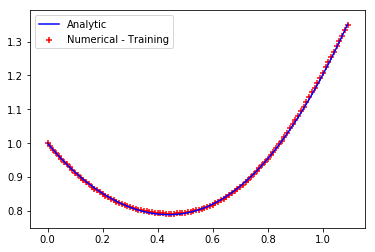

In [8]:
pred_train = solution1.call(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
# plt.plot(X_train, pred_train)
plt.plot(X_test, np.exp(-0.5*X_test**2)/(1+X_test+X_test**3) + X_test**2, c='b', label='Analytic')
plt.legend()
plt.show()

## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [9]:
inits2 = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':constant(0)}]

Defining the domain - train and test input sets.

In [10]:
X_train2 = np.arange(0, 2., 0.2) + 1e-8
X_train2 = X_train2.reshape(-1,1)
X_test2 = np.arange(0, 2., 0.01) + 1e-8
X_test2 = X_test2.reshape(-1,1) 

The loss for this equation.

In [11]:
def diff_loss2(network, inputs, *args):
  with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(inputs)
    tape.watch(inputs)
    response = network(inputs)
    
  grads = tape.gradient(response, inputs)
  delta = tf.reshape(grads, shape=(-1,))
  
  psi = tf.reshape(response, shape=(-1,))
  
  X = tf.reshape(inputs, shape=(-1,))
  
  loss = tf.square(delta + 0.2 * psi
          - tf.exp( -0.2 * X) * tf.cos(X))
  return tf.math.reduce_mean(loss)

In [20]:
solution2 = Solution(n_i=1, n_h=50, n_o=1)

In [21]:
solution2.train(X=X_train2, loss_function=diff_loss2, conditions=inits2,
                verbose=True, epochs=1000, message_frequency=100, learning_rate=0.1)

Epoch: 100 Loss equation:               0.0038179035709227844               Loss boundary: 7.168844146407709e-10
Epoch: 200 Loss equation:               0.0028769649220968456               Loss boundary: 1.688984466127529e-08
Epoch: 300 Loss equation:               0.0023552818297210712               Loss boundary: 7.04370454929101e-09
Epoch: 400 Loss equation:               0.0019148569239617421               Loss boundary: 2.2606600914601253e-09
Epoch: 500 Loss equation:               0.001558448111439258               Loss boundary: 3.75495114272431e-10
Epoch: 600 Loss equation:               0.0012816771673500988               Loss boundary: 3.273249937553499e-12
Epoch: 700 Loss equation:               0.014159437132047153               Loss boundary: 0.03602022124502273
Epoch: 800 Loss equation:               0.002005554744722617               Loss boundary: 8.49822671855588e-08
Epoch: 900 Loss equation:               0.0010008336483976446               Loss boundary: 2.5201541250

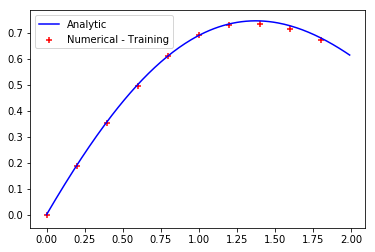

In [22]:
pred_train2 = solution2.call(tf.convert_to_tensor(X_train2, dtype='float64')).numpy()
plt.scatter(X_train2, pred_train2, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test2,  np.exp(-0.2*X_test2)*np.sin(X_test2), c='b', label='Analytic')
plt.legend()
plt.show()

## Example 3

$\frac{d^2}{dx^2}\Psi+\frac{1}{5}\frac{d}{dx}\Psi+\Psi=-\frac{1}{5}\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$, $\frac{d}{dx}\Psi(0)=1$ and domain $x\in[0,2]$

In [15]:
inits3 = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':constant(0)},
        {'variable':0, 'value':0, 'type':'neuman',
        'function':constant(1)}]

The loss for this equation.

In [16]:
def diff_loss3(network, inputs, *args):
  # Compute the gradients
  with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
      inputs = tf.convert_to_tensor(inputs)
      tape.watch(inputs)
      tape2.watch(inputs)
      response = network(inputs)  
    grads = tape.gradient(response, inputs)
  laplace = tape2.gradient(grads, inputs)
  
  # Compute the loss
  nabla = tf.reshape(laplace, shape=(-1,))
  delta = tf.reshape(grads, shape=(-1,))
  psi = tf.reshape(response, shape=(-1,))
  X = tf.reshape(inputs, shape=(-1,))
  loss = tf.square(nabla + 0.2*delta + psi + 0.2*tf.exp( -0.2 * X) * tf.cos(X))
  return tf.math.reduce_mean(loss)

In [17]:
solution3 = Solution(n_i=1, n_h=50, n_o=1)

In [18]:
solution3.train(X=X_train2, loss_function=diff_loss3, conditions=inits3,
                verbose=True, epochs=1000, message_frequency=100, learning_rate=0.1)

Epoch: 100 Loss equation:               0.07626097266372997               Loss boundary: 0.0016039164145613077
Epoch: 200 Loss equation:               0.026857427547025588               Loss boundary: 0.00023367474358328285
Epoch: 300 Loss equation:               0.010063568728982949               Loss boundary: 3.760130168753619e-05
Epoch: 400 Loss equation:               0.0038539376861869605               Loss boundary: 6.459670963153556e-06
Epoch: 500 Loss equation:               0.001396687463558722               Loss boundary: 1.088582967106492e-06
Epoch: 600 Loss equation:               0.10814284700148095               Loss boundary: 1.3868787859645746
Epoch: 700 Loss equation:               0.00020999287884687864               Loss boundary: 4.890671461417493e-08
Epoch: 800 Loss equation:               8.869266122154793e-05               Loss boundary: 8.081358976563915e-09
Epoch: 900 Loss equation:               4.5758975112262316e-05               Loss boundary: 3.2208795885

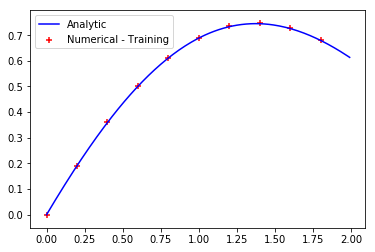

In [19]:
pred_train3 = solution3.call(tf.convert_to_tensor(X_train2, dtype='float64')).numpy()
plt.scatter(X_train2, pred_train3, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test2, np.exp(-0.2*X_test2)*np.sin(X_test2), c='b', label='Analytic')
plt.legend()
plt.show()